# Canopy Height Map

{octicon}`calendar` Apr, 2025 

{bdg-primary-line}`GIS raster dataset processing`

This notebook processes canopy height maps of a selected area of interest. Once the area has been defined, corresponding GeoTIFF files are downloaded. These TIF files are tree height datasets, which are then converted into GeoPandas dataframes for analysis and for exporting the results to GeoJSON or CSV files.

Below is the flowchart illustrating the process in this notebook:

![](img/mermaid.png)

**Reference:**

> High Resolution Canopy Height Maps by WRI and Meta
> Global and regional Canopy Height Maps (CHM). Created using machine learning models on high-resolution worldwide Maxar satellite imagery.
> 
> Documentation: https://github.com/facebookresearch/HighResCanopyHeight  
> Contact: dataforgood@meta.com  
> ManagedBy: Meta:  https://dataforgood.fb.com/    
> Meta and World Resources Institude (WRI) - 2024. High Resolution Canopy Height Maps (CHM). Source imagery for CHM © 2016 [Maxar](https://www.maxar.com/products/imagery-basemaps).
>
>  ![](img/chm.jpg)


In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import s3fs  # File interface to AWS S3

## Download world tiles
The data is stored on AWS as open data, so no AWS account is needed to access it.

In [7]:
# 'anon=True' disables signing for public data
fs = s3fs.S3FileSystem(anon=True)

# Define resource and location in S3
bucket = "dataforgood-fb-data"
path = "forests/v1/alsgedi_global_v6_float"
filename = "tiles.geojson"

# Define local path to save the file
local_path = "tiles.geojson"

# Download the file
fs.get(f"{bucket}/{path}/{filename}", local_path)

# Read GeoJSON into a GeoDataFrame
tiles = gpd.read_file(local_path)
tiles

,tile,geometry
0,023013213,"POLYGON ((-115.3125 33.13755, -115.3125 33.724..."
1,021210020,"POLYGON ((-123.04688 54.57206, -123.04688 54.9..."
2,130122211,"POLYGON ((115.3125 56.94497, 115.3125 57.32652..."
3,121022223,"POLYGON ((46.40625 55.77657, 46.40625 56.17002..."
4,310111000,"POLYGON ((130.07812 -0.70311, 130.07812 0, 129..."
...,...,...
56140,122321030,"POLYGON ((30.23438 9.1021, 30.23438 9.79568, 2..."
56141,132032310,"POLYGON ((106.17188 23.88584, 106.17188 24.527..."
56142,300131332,"POLYGON ((44.29688 -16.63619, 44.29688 -15.961..."
56143,030303300,"POLYGON ((-58.35938 50.28934, -58.35938 50.736..."


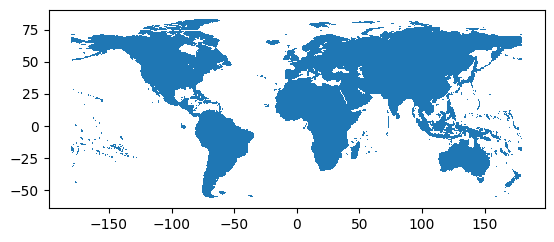

In [8]:
tiles.plot()
plt.show()

The selected area could lie in between more than one tile as it can be observed opening the `tiles.geojson` file in a tool like https://geojson.io/:

![](img/tiles_.jpg)

## Import area of interest
For example, we can import GeoJSON file from a polygon drawn in https://geojson.io/:

![](img/polygon.jpg)

In [23]:
area = gpd.read_file("zumaia.geojson")
area

,geometry
0,"POLYGON ((-2.25979 43.29366, -2.25385 43.2927,..."


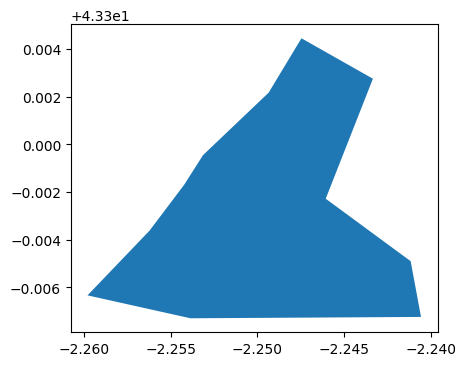

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
area.plot(ax=ax)
plt.show()

## Find intersecting tiles
By intersecting the global tiles with the area of interest, we can identify the relevant tiles and the geometry of the area that lies within the corresponding tile.

In [25]:
# Change coordinate reference to Web Mercator
tiles = tiles.to_crs("EPSG:3857")
area = area.to_crs("EPSG:3857")

# Get intersection
area_tiles = gpd.overlay(area, tiles, how="intersection")
area_tiles = area_tiles[["tile", "geometry"]]
area_tiles

,tile,geometry
0,031333122,"POLYGON ((-251160.568 5357192.823, -250938.305..."


In this case only one tile intersects with the area of interest.

## Download cropped tiles
Tiles with canopy height map datasets are provided in GIS raster format (TIF files) for download. However, due to their large size, only a subset will be downloaded, cropped to match the boundaries (X, Y, maximum and minimum) of the polygons.

In [26]:
cropped_tiles = []

# For each tile involved
for tile in area_tiles["tile"]:

    # Define existing file name in S3
    filename = f"{tile}.tif"

    # Define S3 path
    s3_url = f"s3://{bucket}/{path}/chm/{filename}"

    # Get the GeoTIFF file
    file = fs.open(s3_url)

    # Open it as a GIS raster dataset
    with rasterio.open(file) as dataset:

        # Get the boundaries of the area inside the tile
        min_x, min_y, max_x, max_y = area_tiles[area_tiles["tile"] == tile].union_all().bounds

        # Get the window to read
        window = rasterio.windows.from_bounds(min_x, min_y, max_x, max_y, transform=dataset.transform)

        # Read the 2D map, 1 band: canopy heights
        cropped_data = dataset.read(1, window=window)
    
        # Store the relevant metadata
        metadata = dataset.profile
        metadata.update({
            "driver": "GTiff",
            "count": 1,  # Single band
            "dtype": "float32",
            "width": cropped_data.shape[1],
            "height": cropped_data.shape[0],
            "transform": dataset.window_transform(window),
        })

        # Save the dataset as a .tif file
        cropped_filename = f"cropped_{tile}.tif"
        with rasterio.open(cropped_filename, "w", **metadata) as dst:
            dst.write(cropped_data, 1)

        # Store the file name for the composition later
        cropped_tiles.append(cropped_filename)

## Compose the mosaic
After they are downloaded, the individual tile sections must be merged into a new GIS raster file corresponding to the target area.

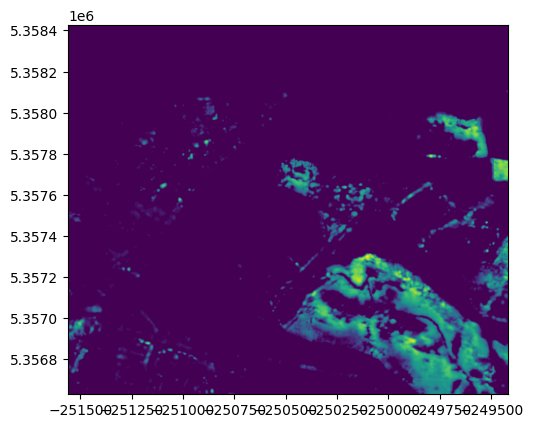

In [27]:
# Open datasets from cropped tiles
datasets = []
for cropped_tile in cropped_tiles:
    datasets.append(rasterio.open(cropped_tile))

# Show them using rasterio's show function
fig, ax = plt.subplots()
show(datasets[0], ax=ax, cmap="viridis")  # Only one in this case
plt.show()

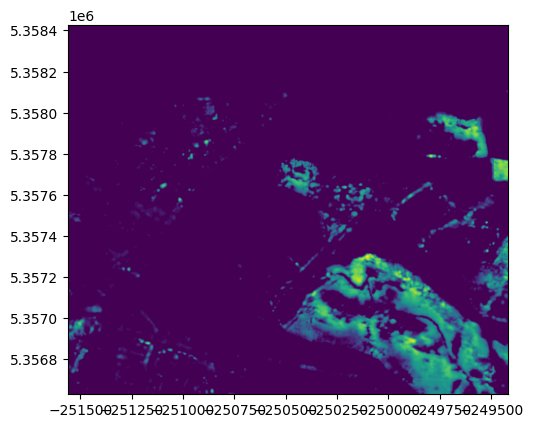

In [28]:
# Merge raster files
mosaic_image, mosaic_transform = rasterio.merge.merge(datasets)

# Set up the metadata for the output file (using the profile of the first tile)
out_meta = datasets[0].profile
out_meta.update({
    "driver": "GTiff",
    "count": 1,  # Single band output
    "transform": mosaic_transform,
    "width": mosaic_image.shape[2],  # Width is the 3rd dimension of the 3D array (bands, height, width)
    "height": mosaic_image.shape[1],  # Height is the 2nd dimension
})

# Save the mosaic to a file
output_file = "mosaic.tif"
with rasterio.open(output_file, "w", **out_meta) as dst:
    dst.write(mosaic_image[0], 1)  # Since it's single-band, we need to write only the first band

# Close all datasets manually to ensure they're not locked
for dataset in datasets:
    dataset.close()  # Explicitly close each dataset

# Optionally, clean up the temporary files
for cropped_tile in cropped_tiles:
    os.remove(cropped_tile)

# Show the result
with rasterio.open(output_file) as dst:
    show(dst, cmap="viridis")
    plt.show()

## Obtain canopy height map
The GIS raster file is read into a dataset to extract the canopy height map information, which is then transferred into a GeoPandas dataframe.

In [29]:
with rasterio.open(output_file) as dataset:
    indexes = dataset.indexes # Supposedly only 1 band -> heights
    heights = dataset.read(indexes[0]) # Read 2D array: map of the heights
    geo_xy = dataset.xy # Get handy function for spatial indexing

    # Replace zeros with NaN in 2D array
    heights[heights == 0] = np.nan

    # Get 2D array indices of non-NaN values
    indices = np.where(~np.isnan(heights))

    # Get non-NaN values: heights (in meters)
    values = heights[indices]

    # Array positions -> Spatial coordinates
    X, Y = geo_xy(indices[0], indices[1])

    # Convert to geometry points
    points = [Point(xy) for xy in zip(X, Y)]

    gdf = gpd.GeoDataFrame({"height": values}, geometry=points, crs="EPSG:3857")

gdf

,height,geometry
0,1.0,POINT (-249426.436 5358106.388)
1,1.0,POINT (-249425.242 5358106.388)
2,1.0,POINT (-249424.048 5358106.388)
3,2.0,POINT (-249422.853 5358106.388)
4,2.0,POINT (-249421.659 5358106.388)
...,...,...
418192,2.0,POINT (-249474.209 5356630.198)
418193,2.0,POINT (-249473.015 5356630.198)
418194,2.0,POINT (-249471.821 5356630.198)
418195,1.0,POINT (-249470.626 5356630.198)


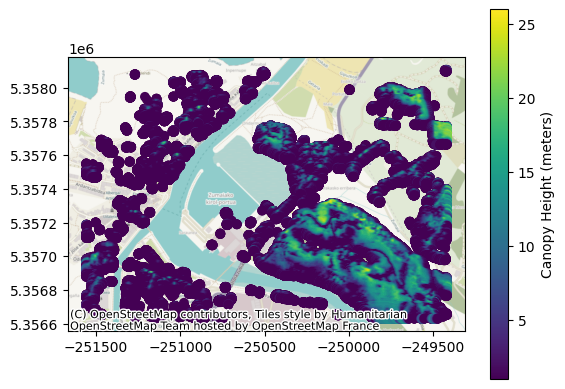

In [30]:
fig, ax = plt.subplots()
legend_kwds = {"label": "Canopy Height (meters)"}
gdf.plot(ax=ax, column="height", legend=True, legend_kwds=legend_kwds)
ctx.add_basemap(ax, crs=gdf.crs)
plt.show()

## Clip the original area
Lastly, the GeoDataFrame is clipped to retain only the original area.

In [31]:
gdf_area = gpd.sjoin(gdf, area)
gdf_area = gdf_area.drop("index_right", axis=1)
gdf_area

,height,geometry
4277,1.0,POINT (-249997.325 5357990.538)
4278,1.0,POINT (-249996.131 5357990.538)
4279,1.0,POINT (-249994.937 5357990.538)
4280,1.0,POINT (-249993.742 5357990.538)
4393,1.0,POINT (-249997.325 5357989.344)
...,...,...
417920,3.0,POINT (-250883.517 5356630.198)
417921,2.0,POINT (-250882.323 5356630.198)
417922,2.0,POINT (-250881.128 5356630.198)
417923,1.0,POINT (-250879.934 5356630.198)


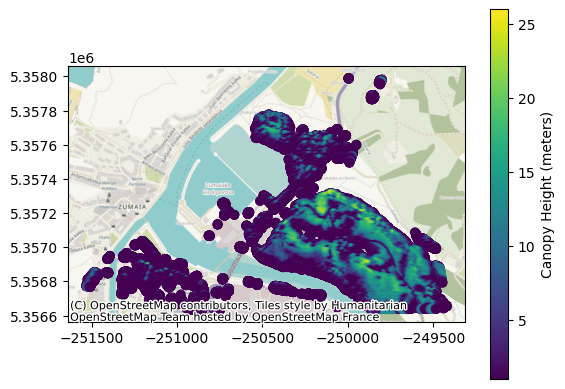

In [32]:
fig, ax = plt.subplots()
legend_kwds = {"label": "Canopy Height (meters)"}
gdf_area.plot(ax=ax, column="height", legend=True, legend_kwds=legend_kwds)
ctx.add_basemap(ax, crs=gdf.crs)
plt.show()

The GeoPandas dataframe allows us to analyze the data — for instance, we can explore the distribution of heights:

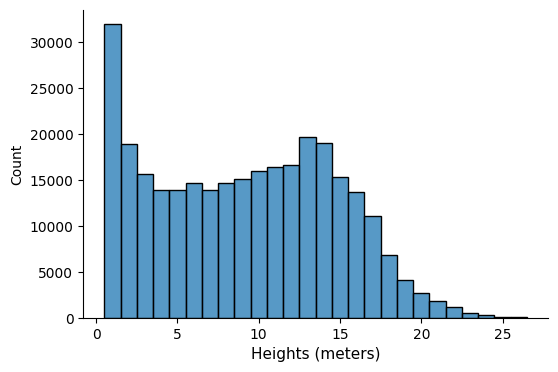

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(gdf_area["height"], ax=ax, stat="count", discrete=True)
ax.set_xlabel("Heights (meters)", fontsize=11)
sns.despine()
plt.show()

## Export (CSV, GeoJSON)

In [34]:
# Define output
filename = "chm"
gdf_area = gdf_area.to_crs("EPSG:4326")

# To GeoJSON
gdf_area.to_file(f"{filename}.geojson", driver="GeoJSON")

# To CSV, with latitude, longitude in columns
gdf_area["lat"] = gdf_area["geometry"].y
gdf_area["lon"] = gdf_area["geometry"].x
gdf_area = gdf_area.drop("geometry", axis=1)
gdf_area.to_csv(f"{filename}.csv")